## 통신사 고객 이탈 예측

- 데이터는 https://www.kaggle.com/blastchar/telco-customer-churn 를 참조
- 본 데이터는 IBM Sample Data Sets에서 다운받아 공유된 것임.(https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/)
- 특성은 21개, 레코드는 7,043개
- 분석의 목적 : 왜 고객이 이탈하게 되는가? 이탈고객들의 특성은 어떠한가?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from decimal import Decimal

In [2]:
tele_data = pd.read_csv('C:/Users/mosunghoon/Documents/GitHub/Kaggle Analysis/Kaggle_Analysis/raw data warehouse/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
tele_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 데이터 특성 설명
- customerID : 고객 ID
- gender : 성별 (Male / Female)
- SeniorCitizen : 노년층 여부 (1, 0)
- Partner : 결혼 여부 (Yes, No)
- Dependents : 부양가족 여부 (Yes, No)
- tenure : 고객 가입 이후 개월 수
- PhoneService : 전화서비스 가입 여부 (Yes, No)
- MultipleLines : 다중 전화선 사용 여부 (Yes, No, No Phone Service)
- InternetService : 인터넷 연결 방식 (DSL, Fiber optic, No)
- OnlineSecurity : 온라인 보안 서비스 사용 여부 (Yes, No, No internet service)
- OnlineBackUp : 온라인 백업 서비스 사용 여부 (Yes, No, No internet service)
- DeviceProtection : 기기 보험 가입 여부 (Yes, No, No internet service)
- TechSupport : 인터넷 기술지원 서비스 가입 여부 (Yes, No, No internet service)
- StreamingTV : TV 프로그램 Streaming 서비스 가입 여부 (Yes, No, No internet service)
- StreamingMovies : 영화 Streaming 서비스 가입 여부 (Yes, No, No internet service)
- Contract : 계약 형태 (Month-to-month, One year, Two year)
- PaperlessBilling : 전자영수증 발급 여부 (Yes, No)
- PaymentMethod : 결제 방법 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges : 월 지급 요금 
- TotalCharges : 총 지급 요금 
- Churn : 고객 이탈 여부 (Yes, No)

In [ ]:
tele_data.info()

### 데이터 전처리
- 데이터 타입 확인 시, 연속형 데이터이어야 할 TotalCharges의 속성이 명목형 데이터로 되어있음. 이를 float형태로 바꿔야 함.
- SeniorCitizen 속성은 반대로 명목형인데 int 형식으로 인식되어 있음. 이를 명목형으로 전환해야함.

In [ ]:
tele_data['TotalCharges'] = tele_data['TotalCharges'].apply(pd.to_numeric, errors='coerce')
tele_data.SeniorCitizen.replace((1,0),('Yes','No'), inplace=True)
tele_data = tele_data.drop('customerID',1)
tele_data = tele_data.dropna(axis=0)

- 추후 분석 진행을 위해 데이터 값을 더미 변수로 전환

In [ ]:
###### dummy 전환
tele_data.gender.replace(('Male', 'Female'),(0, 1), inplace=True)
tele_data.Partner.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.Dependents.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.MultipleLines.replace(('Yes', 'No', 'No phone service'),(2, 1, 0), inplace=True)
tele_data.InternetService.replace(('DSL', 'Fiber optic', 'No'),(1, 2, 0), inplace=True)
tele_data.OnlineSecurity.replace(('Yes', 'No', 'No internet service'),(2, 1, 0), inplace=True)
tele_data.OnlineBackup.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.DeviceProtection.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.TechSupport.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.StreamingTV.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.StreamingMovies.replace(('Yes', 'No','No internet service'),(2, 1, 0), inplace=True)
tele_data.PhoneService.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.Contract.replace(('Month-to-month', 'One year', 'Two year'),(0, 1, 2), inplace=True)
tele_data.PaperlessBilling.replace(('Yes', 'No'),(1, 0), inplace=True)
tele_data.PaymentMethod.replace(('Electronic check', 'Mailed check', 'Bank transfer (automatic)',
                                 'Credit card (automatic)'),(1, 2, 3, 4), inplace=True)
tele_data.Churn.replace(('Yes', 'No'),(1, 0), inplace=True)

In [ ]:
tele_data.head()

## 탐색적 데이터 분석

#### 가입기간 별 고객 분포

In [5]:
def CreateGrp(tn):
    if ((tn >= 0) & (tn <= 12)):
        return('[0-12]')
    elif ((tn > 12) & (tn <= 24)):
        return('[12-24]')
    elif ((tn > 24) & (tn <= 36)):
        return('[24-36]')
    elif ((tn > 36) & (tn <= 48)):
        return('[36-48]')
    elif ((tn > 48) & (tn <= 60)):
        return('[48-60]')
    else:
        return('[> 60]')
    
tele_data['tenureBin'] = tele_data['tenure'].apply(lambda x: CreateGrp(x))

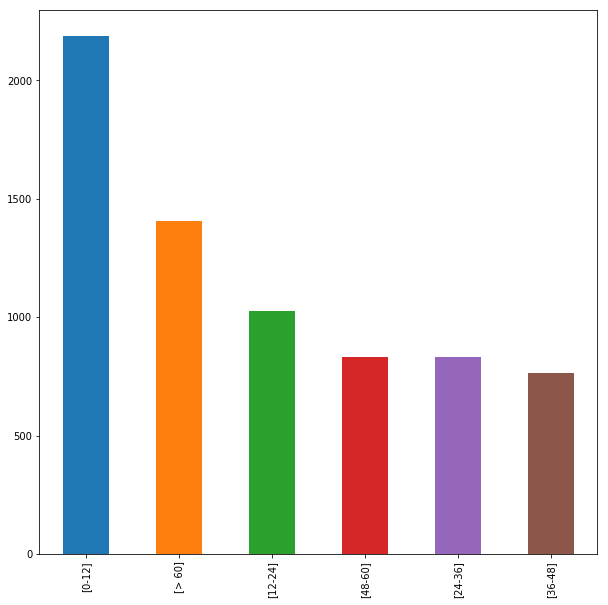

In [6]:
plt.figure(figsize = (10,10))
tele_data['tenureBin'].value_counts().plot(kind='bar')

- 가입 기간이 1년 이내인 고객들이 가장 많았음.
- 5년 이상의 장기 고객들이 그 다음으로 많았으며, 가입 기간이 1년 이상으로 넘어서면 고객 수가 절반 이하로 떨어짐

In [7]:
%matplotlib inline

#### 기간 별 고객들의 이탈 분포

In [8]:
def plotStackChart(df, col1, col2 ):
    plt.figure(figsize = (15,15))
    df = df.groupby([col1, col2])[col2].count().fillna(0).groupby(level=[0]).apply(lambda x: x / x.sum()).unstack(col2)
    df.plot(kind='bar', color=colors, stacked=True, title = 'Customer churn by tenure')

In [9]:
colors = ["#d0d0d0", "#E69F00"]

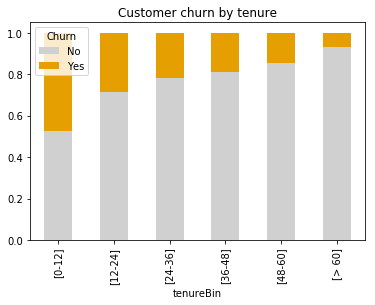

In [10]:
plotStackChart(tele_data, 'tenureBin', 'Churn')

In [24]:
singyu = tele_data[tele_data['tenureBin']=='[0-12]']

In [31]:
len(singyu)

2186

In [30]:
len(singyu[singyu['Churn']=='Yes'])/len(singyu) *100 

1037

- 가입 1년 이내의 고객들에게서 고객 이탈이 가장 많이 나타나고 있음.
  (총 2,186 명의 고객들 중에서  1,037 명이 이탈했으며, 비율로 따지면 47% 정도 됨.

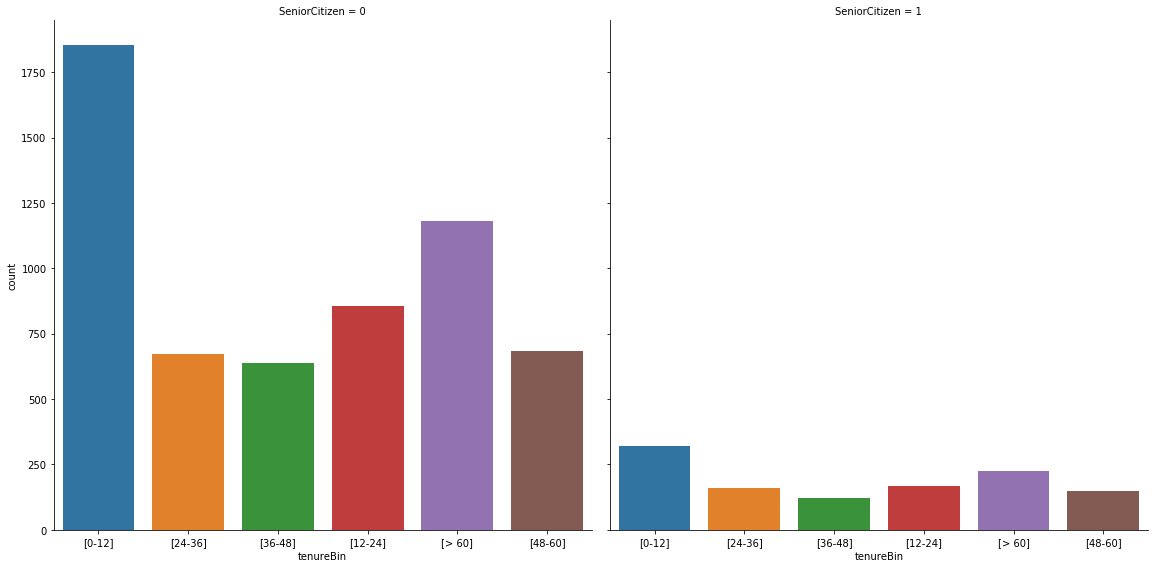

In [35]:
sns.factorplot(x='tenureBin', col='SeniorCitizen', kind='count', size=8, data=tele_data);

In [ ]:
sns.factorplot(x='DeviceProtection', col='Churn', kind='count', data=tele_data);

In [ ]:
sns.factorplot(x='PaymentMethod', col='Churn', kind='count', size=8, data=tele_data);

In [ ]:
sns.factorplot(x='StreamingTV', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='StreamingTV', kind='count', data=tele_data);
sns.factorplot(x='OnlineBackup', kind='count', data=tele_data);
sns.factorplot(x='OnlineSecurity', kind='count', data=tele_data);
sns.factorplot(x='TechSupport', kind='count', data=tele_data);
sns.factorplot(x='DeviceProtection', kind='count', data=tele_data);
sns.factorplot(x='InternetService', kind='count', data=tele_data);
sns.factorplot(x='InternetService', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='StreamingTV', col='StreamingMovies', kind='count', data=tele_data);
sns.factorplot(x='StreamingMovies', col='StreamingTV', kind='count', data=tele_data);
sns.factorplot(x='PhoneService', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='SeniorCitizen', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='InternetService', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='InternetService', col='Contract', kind='count', data=tele_data);
sns.factorplot(x='Contract', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='Dependents', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='MultipleLines', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='PhoneService', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='Partner', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='Contract', kind='count', data=tele_data);
sns.factorplot(x='TechSupport', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='PaperlessBilling', col='Churn', kind='count', data=tele_data);
sns.factorplot(x='PaymentMethod', col='Churn', kind='count', size=10, data=tele_data);
sns.factorplot(x='Dependents', col='Churn', kind='count', data=churny);
sns.factorplot(x='Partner', col='Churn', kind='count', data=churny);
sns.factorplot(x='Partner', col='StreamingMovies', kind='count', data=tele_data);
sns.factorplot(x='Dependents', col='StreamingMovies', kind='count', data=tele_data);
sns.factorplot(x='Dependents', col='Contract', kind='count', data=tele_data);
sns.factorplot(x='InternetService', col='tenureBin', kind='count', data=tele_data);

### 상관분석

In [327]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

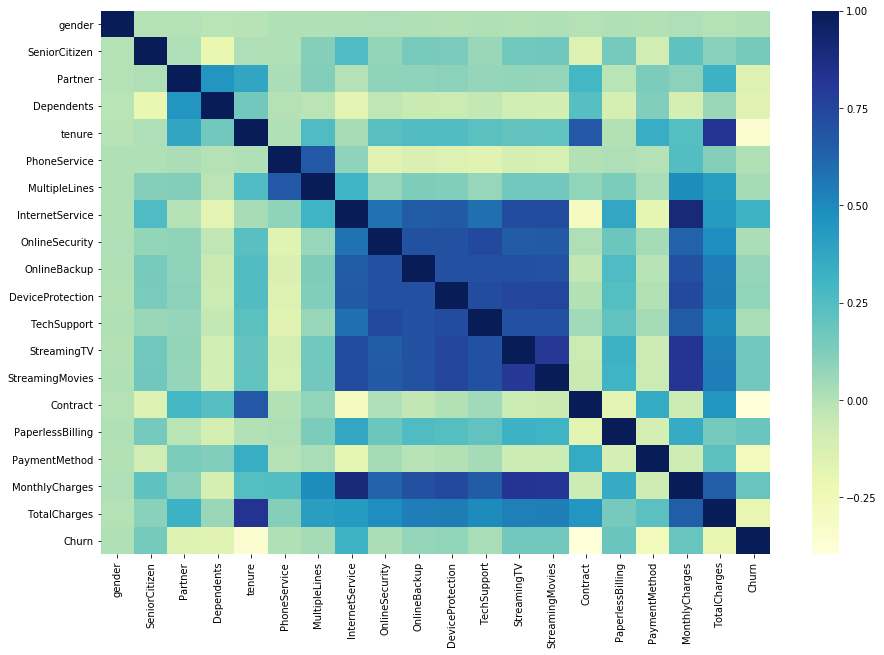

In [60]:
fig = plt.figure(figsize=(15,10))
corr = tele_data.corr(method = 'pearson')
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [12]:
corr_stack = corr.abs().unstack()
ordered_stack = corr_stack.sort_index(ascending=False)
order_corr = []

for num in range(len(ordered_stack)):
    if ordered_stack[num] > 0.7 and ordered_stack[num] < 1.0:
        order_corr.append(num)
        
print(ordered_stack[order_corr])

tenure            TotalCharges        0.825880
TotalCharges      tenure              0.825880
TechSupport       StreamingTV         0.703306
                  StreamingMovies     0.704595
                  OnlineSecurity      0.734696
                  OnlineBackup        0.708659
                  DeviceProtection    0.724817
StreamingTV       TechSupport         0.703306
                  StreamingMovies     0.807118
                  OnlineBackup        0.702605
                  MonthlyCharges      0.820193
                  InternetService     0.725522
                  DeviceProtection    0.747489
StreamingMovies   TechSupport         0.704595
                  StreamingTV         0.807118
                  MonthlyCharges      0.817525
                  InternetService     0.722592
                  DeviceProtection    0.752755
OnlineSecurity    TechSupport         0.734696
                  OnlineBackup        0.704598
                  DeviceProtection    0.701112
OnlineBackup 

In [13]:
ordered_stack[order_corr]

tenure            TotalCharges        0.825880
TotalCharges      tenure              0.825880
TechSupport       StreamingTV         0.703306
                  StreamingMovies     0.704595
                  OnlineSecurity      0.734696
                  OnlineBackup        0.708659
                  DeviceProtection    0.724817
StreamingTV       TechSupport         0.703306
                  StreamingMovies     0.807118
                  OnlineBackup        0.702605
                  MonthlyCharges      0.820193
                  InternetService     0.725522
                  DeviceProtection    0.747489
StreamingMovies   TechSupport         0.704595
                  StreamingTV         0.807118
                  MonthlyCharges      0.817525
                  InternetService     0.722592
                  DeviceProtection    0.752755
OnlineSecurity    TechSupport         0.734696
                  OnlineBackup        0.704598
                  DeviceProtection    0.701112
OnlineBackup 

In [160]:
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.005285,0.007515,0.010284,0.009643,0.013233,0.011081,0.003168,0.008215,0.007163,0.009072,-0.000095,0.011902,0.004928,0.013779,-0.000048,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.113769,0.259030,0.081766,0.144762,0.140226,0.067318,0.167123,0.176125,-0.141820,0.156258,-0.093712,0.219874,0.102411,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,0.118037,0.000938,0.092034,0.091536,0.099077,0.077252,0.080205,0.076076,0.294094,-0.013957,0.133280,0.097825,0.319072,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.019178,-0.177789,-0.028964,-0.061970,-0.068296,-0.040057,-0.085909,-0.099795,0.240556,-0.110131,0.124002,-0.112343,0.064653,-0.163128
tenure,-0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.259112,0.031272,0.232295,0.253575,0.253834,0.230429,0.200646,0.203834,0.676734,0.004823,0.340939,0.246862,0.825880,-0.354049
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007877,1.000000,0.674824,0.094182,-0.158997,-0.129432,-0.141055,-0.160950,-0.107242,-0.114798,0.003019,0.016696,-0.003106,0.248033,0.113008,0.011691
MultipleLines,0.010284,0.113769,0.118037,-0.019178,0.259112,0.674824,1.000000,0.308546,0.069959,0.130978,0.125447,0.069706,0.166256,0.163218,0.084037,0.133538,0.026248,0.491412,0.412495,0.036148
InternetService,0.009643,0.259030,0.000938,-0.177789,0.031272,0.094182,0.308546,1.000000,0.581993,0.658487,0.662791,0.585745,0.725522,0.722592,-0.288855,0.377644,-0.178655,0.905389,0.428212,0.316350
OnlineSecurity,0.013233,0.081766,0.092034,-0.028964,0.232295,-0.158997,0.069959,0.581993,1.000000,0.704598,0.701112,0.734696,0.661541,0.666682,0.016495,0.184449,0.035563,0.635260,0.483157,0.023014
OnlineBackup,0.011081,0.144762,0.091536,-0.061970,0.253575,-0.129432,0.130978,0.658487,0.704598,1.000000,0.710790,0.708659,0.702605,0.699828,-0.034745,0.260691,-0.003786,0.710175,0.537726,0.073934


- 상관분석 결과, 가입 개월수와 지급 금액 수는 높은 상관관계를 보여주고 있음(0.82)
- 인터넷 가입자의 경우, 온라인 보안, 백업 서비스, 장비 보험, 기술 지원, TV 스트리밍, 영화 스트리밍 서비스 등의 가입 여부와 높은 상관관계를 보임
- 하지만, 가입 여부와 가입 수준 등 범주형 변수이므로, pearson 상관계수를 확인하는 것이 적절한 것인지 의문
- 그래서 spearman의 상관계수 방식을 통해 독립성을 검증해보자

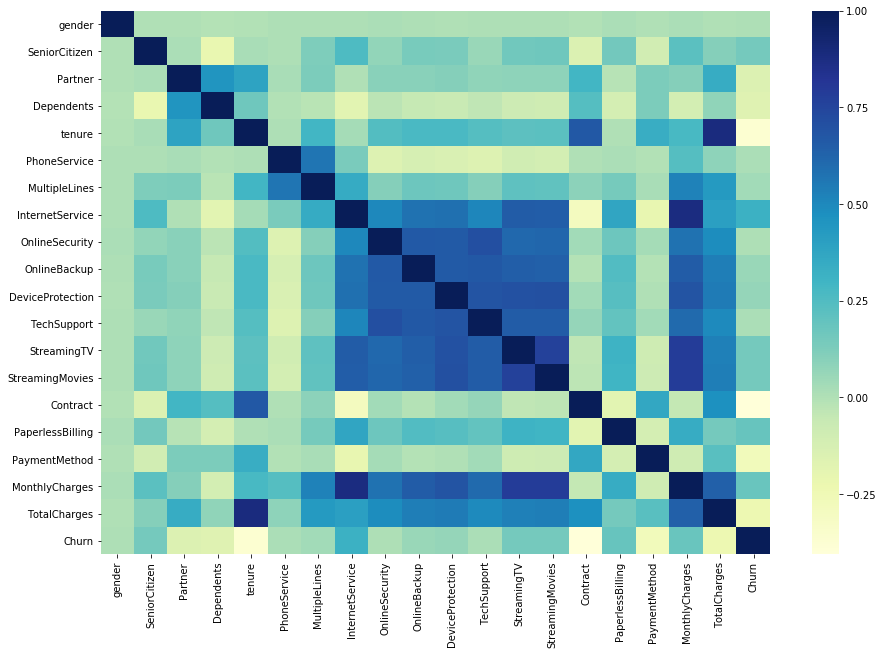

In [61]:
fig = plt.figure(figsize=(15,10))
corr_sprm = tele_data.corr(method = 'spearman')
sns.heatmap(corr_sprm, cmap="YlGnBu")
plt.show()

In [62]:
corr_sprm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,0.001819,0.001379,-0.010349,-0.003718,0.007515,0.010082,0.010150,0.013542,0.011472,0.002948,0.008314,0.007280,0.009390,-0.001037,0.011902,0.004651,0.013085,0.001177,0.008545
SeniorCitizen,0.001819,1.000000,0.016957,-0.210550,0.017408,0.008392,0.125338,0.263197,0.075307,0.137975,0.133141,0.059887,0.160605,0.170399,-0.143143,0.156258,-0.103386,0.220737,0.107248,0.150541
Partner,0.001379,0.016957,1.000000,0.452269,0.387972,0.018397,0.128250,0.001018,0.095975,0.098607,0.106674,0.080719,0.088308,0.083946,0.295210,-0.013957,0.130683,0.109456,0.343196,-0.149982
Dependents,-0.010349,-0.210550,0.452269,1.000000,0.169018,-0.001078,-0.021191,-0.178395,-0.022647,-0.053118,-0.059998,-0.033928,-0.076826,-0.091947,0.241624,-0.110131,0.128859,-0.105449,0.082890,-0.163128
tenure,-0.003718,0.017408,0.387972,0.169018,1.000000,0.007734,0.292442,0.031182,0.242226,0.270167,0.272358,0.241211,0.220248,0.223981,0.673986,0.005955,0.337963,0.275339,0.889177,-0.369659
PhoneService,0.007515,0.008392,0.018397,-0.001078,0.007734,1.000000,0.567931,0.136641,-0.156444,-0.122512,-0.135082,-0.158355,-0.096024,-0.104107,0.002543,0.016696,-0.003083,0.240266,0.084910,0.011691
MultipleLines,0.010082,0.125338,0.128250,-0.021191,0.292442,0.567931,1.000000,0.350194,0.105219,0.170904,0.166565,0.105191,0.210075,0.208002,0.089813,0.145852,0.019937,0.526447,0.430896,0.038156
InternetService,0.010150,0.263197,0.001018,-0.178395,0.031182,0.136641,0.350194,1.000000,0.505543,0.582418,0.587933,0.509000,0.656583,0.652090,-0.286951,0.374351,-0.204973,0.884535,0.403318,0.320636
OnlineSecurity,0.013542,0.075307,0.095975,-0.022647,0.242226,-0.156444,0.105219,0.505543,1.000000,0.667961,0.664227,0.710808,0.611327,0.616422,0.035108,0.174859,0.031355,0.577432,0.487169,0.011566
OnlineBackup,0.011472,0.137975,0.098607,-0.053118,0.270167,-0.122512,0.170904,0.582418,0.667961,1.000000,0.664379,0.671877,0.647114,0.643049,-0.008393,0.249267,-0.007736,0.659291,0.534767,0.057207


In [63]:
corr_stack = corr_sprm.abs().unstack()
ordered_stack = corr_stack.sort_index(ascending=False)
order_corr = []

for num in range(len(ordered_stack)):
    if ordered_stack[num] > 0.7 and ordered_stack[num] < 1.0:
        order_corr.append(num)
        
print(ordered_stack[order_corr])

tenure            TotalCharges        0.889177
TotalCharges      tenure              0.889177
TechSupport       OnlineSecurity      0.710808
StreamingTV       StreamingMovies     0.765461
                  MonthlyCharges      0.789943
                  DeviceProtection    0.700557
StreamingMovies   StreamingTV         0.765461
                  MonthlyCharges      0.786510
                  DeviceProtection    0.706175
OnlineSecurity    TechSupport         0.710808
MonthlyCharges    StreamingTV         0.789943
                  StreamingMovies     0.786510
                  InternetService     0.884535
InternetService   MonthlyCharges      0.884535
DeviceProtection  StreamingTV         0.700557
                  StreamingMovies     0.706175
dtype: float64


- 분석 결과, 피어슨 상관계수와 유사한 결과가 나왓으나, 스피어만 상관계수에서는 특성 간 상관계수 수준이 조금 낮아짐
- 그 중에서도 0.8 이상의 상관계수를 기록하는 특성-관계를 고름
- tenure, StreamingMovies를 삭제하기로 함

In [14]:
#다중공선성 문제를 일으킬 가능성이 있는 특성 삭제
tele_data = tele_data.drop('tenure', 1)

In [15]:
tele_data = tele_data.drop('StreamingMovies', 1)

In [183]:
tele_data = tele_data.drop('PhoneService', 1)

In [159]:
tele_data = tele_data.drop('StreamingTV', 1)

In [353]:
tele_data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
tenureBin            object
dtype: object

- 모형 설계에 앞서, Churn 여부에 대한 case 수의 균형을 확인

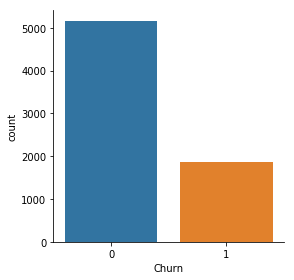

In [39]:
sns.factorplot(x='Churn', kind='count', data=tele_data);

In [40]:
tele_data.groupby(tele_data.Churn).count()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
Churn,,,,,,,,,,,,,,,,,,,
0,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163,5163
1,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869


In [19]:
tele_data.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.495307,0.162400,0.482509,0.298493,0.903299,1.325228,1.224118,1.070392,1.128697,1.127702,1.073948,1.168231,0.688567,0.592719,2.315557,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,0.295571,0.642585,0.778643,0.705562,0.737917,0.737415,0.707715,0.756518,0.832934,0.491363,1.149523,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,35.587500,401.450000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,118.750000,8684.800000,1.000000


- 고객 이탈/비이탈의 case 수가 5170 : 1870 정도로 나옴
- 언더샘플링을 통해 case 수의 균형을 맞출 필요가 있음

In [145]:
# 이탈 case 빈도 확인
len(tele_data[tele_data['Churn']==1])

1869

In [146]:
# 이탈X case 데이터 확인
tele_data[tele_data['Churn']==0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,1,1,2,1,1,1,1,0,1,1,29.85,29.85,0
1,0,0,0,0,34,1,1,1,2,1,2,1,1,1,1,0,2,56.95,1889.50,0
3,0,0,0,0,45,0,0,1,2,1,2,2,1,1,1,0,3,42.30,1840.75,0
6,0,0,0,1,22,1,2,2,1,2,1,1,2,1,0,1,4,89.10,1949.40,0
7,1,0,0,0,10,0,0,1,2,1,1,1,1,1,0,0,2,29.75,301.90,0
9,0,0,0,1,62,1,1,1,2,2,1,1,1,1,1,0,3,56.15,3487.95,0
10,0,0,1,1,13,1,1,1,2,1,1,1,1,1,0,1,2,49.95,587.45,0
11,0,0,0,0,16,1,1,0,0,0,0,0,0,0,2,0,4,18.95,326.80,0
12,0,0,1,0,58,1,2,2,1,1,2,1,2,2,1,0,4,100.35,5681.10,0
14,0,0,0,0,25,1,1,2,2,1,2,2,2,2,0,1,1,105.50,2686.05,0


- 이탈하지 않은 케이스가 5163건이므로, 이를 1869와 비슷한 수준인 2000개로 맞추고자 함.

In [21]:
# 랜덤하게 첫 행에서부터 2000번째 행까지의 케이스를 선택함
X_under_sample = tele_data[tele_data['Churn']==0][:2000]

In [22]:
# 그리고 언더샘플링한 이탈한 경우(Churn=1)와 이탈하지 않은 경우(Churn=0)의 데이터를 합쳐준다.
X_sample = pd.concat([X_under_sample, tele_data[tele_data['Churn']==1]])

- 여기서, 이후에 training set을 선정할 때, 행 기준으로 갯수를 정해서 선정할 것이므로, 두 case를 섞는다.

In [23]:
X_sample_df = X_sample.sample(frac=1).reset_index(drop=True)

In [24]:
X_sample_df

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,0,0,1,2,2,2,2,2,2,1,3,65.55,4807.45,0
1,0,0,0,0,0,0,1,1,1,2,1,1,0,1,3,39.90,2796.35,0
2,0,0,0,0,1,2,1,2,1,2,1,2,0,0,2,69.50,1199.40,0
3,0,0,0,0,1,1,2,1,2,1,1,2,0,1,1,94.50,2979.20,0
4,0,0,0,0,1,1,2,2,1,2,2,1,1,0,1,84.40,4484.05,0
5,0,0,0,0,1,1,1,1,1,2,1,2,0,1,1,69.35,712.25,0
6,0,0,0,0,1,1,0,0,0,0,0,0,0,1,2,19.60,19.60,1
7,1,0,1,0,1,2,1,2,2,1,2,2,0,1,1,76.20,981.45,0
8,1,0,1,1,0,0,1,2,2,2,1,2,0,1,4,58.60,1502.65,1
9,0,0,1,1,1,1,1,1,1,2,1,1,0,1,1,51.05,415.05,1


- 아주 잘 섞여졌다. 이제 이걸 토대로 데이터를 만들어보자.

In [16]:
X_data = X_sample_df.iloc[:,:-2]
y = X_sample_df.iloc[:,-2]

NameError: name 'X_sample_df' is not defined

In [26]:
x_train, x_test = X_data[:2500], X_data[2500:]
y_train, y_test = y[:2500], y[2500:]

In [27]:
len(x_train)
len(x_test)

1369

In [17]:
X_data = tele_data.iloc[:,:-2]
y = tele_data.iloc[:,-2]

### SVM 분석

In [219]:
from sklearn import datasets, svm, metrics
import datetime as dt

In [251]:
svc = svm.SVC(kernel='linear', C=100.0).fit(x_train, y_train)

KeyboardInterrupt: 

In [247]:
res = svc.predict(x_test)

In [248]:
svc

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [249]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [250]:
print('정확도 : %.2f' %accuracy_score(y_test,res))

정확도 : 0.64


In [225]:
param_C = 5
param_gamma = 0.05
classifier = svm.SVC(C=param_C, kernel = 'rbf', gamma=param_gamma)

# We learn the digits on train part
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))
classifier.fit(x_train, y_train)
end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2018-06-27 03:34:52.762862
Stop learning 2018-06-27 03:34:53.329347
Elapsed learning 0:00:00.566485


In [226]:
expected = y_test
predicted = classifier.predict(x_test)

In [229]:
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.61      0.84      0.71       691
          1       0.73      0.45      0.56       678

avg / total       0.67      0.65      0.63      1369


Confusion matrix:
[[578 113]
 [370 308]]
Accuracy=0.6471877282688093


In [230]:
print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.61      0.84      0.71       691
          1       0.73      0.45      0.56       678

avg / total       0.67      0.65      0.63      1369


Confusion matrix:
[[578 113]
 [370 308]]
Accuracy=0.6471877282688093


- SVM 분석 결과, 모델의 분류 성능은 76% 수준

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

x_train_lr = x_train
x_test_lr = x_test
y_train_lr = y_train
y_test_lr = y_test

lr = LogisticRegression()
lr_fit = lr.fit(x_train_lr, y_train_lr)
cv = StratifiedKFold(n_splits=2)
lr_cv = cross_val_score(lr, x_test_lr, y_test_lr, cv = cv)
score = round(Decimal(np.mean(lr_cv)*100), 2)
print('Accuracy: {}%'.format(score))
lr_fit

NameError: name 'x_train' is not defined

In [232]:
predictions = lr.predict(x_test_lr)

In [233]:
score = lr.score(x_test_lr, y_test_lr)
print(score)

0.7633308984660336


In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [235]:
cm = metrics.confusion_matrix(y_test_lr, predictions)
print(cm)

[[506 185]
 [139 539]]


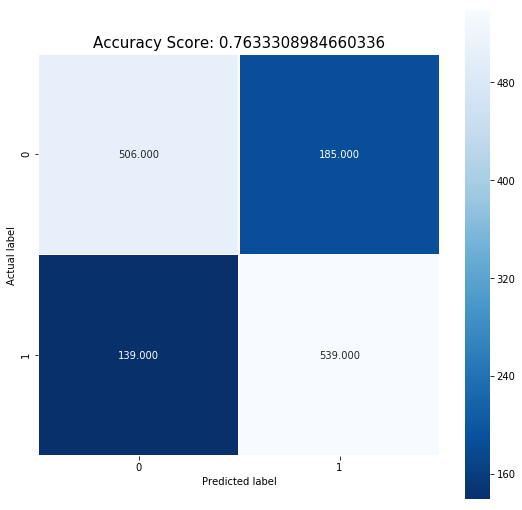

In [236]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [237]:
from sklearn import linear_model

In [238]:
logreg = linear_model.LogisticRegression(C=1e5) # 정규화
logreg.fit(X_data, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

- 로지스틱 모형 분석 결과, 모델의 분류 성능은 81% 수준

In [239]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

fpr1, tpr1, thresholds1 = roc_curve(y, classifier.decision_function(X_data))
fpr2, tpr2, thresholds1 = roc_curve(y, lr_fit.decision_function(X_data))

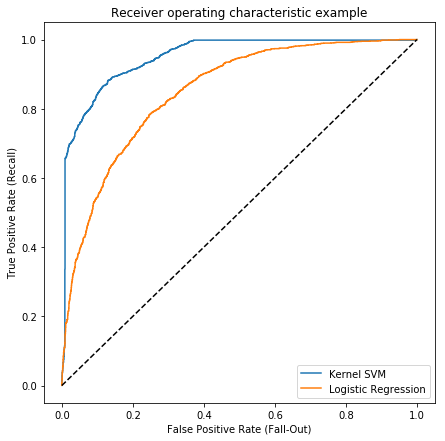

In [240]:
plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, label="Kernel SVM")
plt.plot(fpr2, tpr2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

### Neural Network

In [195]:
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
import time

In [201]:
start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(6,5),
                    max_iter=50, solver='sgd', verbose=1, learning_rate_init=.0015)
mlp.fit(x_train, y_train)

print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1, loss = 2.63900916
Iteration 2, loss = 0.73621954
Iteration 3, loss = 0.73385592
Iteration 4, loss = 0.73110231
Iteration 5, loss = 0.72843382
Iteration 6, loss = 0.72600638
Iteration 7, loss = 0.72349374
Iteration 8, loss = 0.72138536
Iteration 9, loss = 0.71927857
Iteration 10, loss = 0.71733496
Iteration 11, loss = 0.71550220
Iteration 12, loss = 0.71382206
Iteration 13, loss = 0.71229565
Iteration 14, loss = 0.71092478
Iteration 15, loss = 0.70951129
Iteration 16, loss = 0.70830317
Iteration 17, loss = 0.70709758
Iteration 18, loss = 0.70604544
Iteration 19, loss = 0.70504700
Iteration 20, loss = 0.70411256
Iteration 21, loss = 0.70328472
Iteration 22, loss = 0.70245470
Iteration 23, loss = 0.70175300
Iteration 24, loss = 0.70102244
Iteration 25, loss = 0.70038671
Iteration 26, loss = 0.69980939
Iteration 27, loss = 0.69924591
Iteration 28, loss = 0.69876284
Iteration 29, loss = 0.69827406
Iteration 30, loss = 0.69781862
Iteration 31, loss = 0.69743908
Iteration 32, los

C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [15]:
import scipy.stats

In [16]:
import statsmodels.api as sm

In [205]:
x_data_logit = np.asarray(X_data)
y_data_logit = np.asarray(y)

In [206]:
logit = sm.Logit(y, x_data_logit)

In [207]:
result = logit.fit() 

Optimization terminated successfully.
         Current function value: 0.482120
         Iterations 7


In [208]:
result.summary()

AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

In [17]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(y, X_data)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7015
Method:                           MLE   Df Model:                           16
Date:                Thu, 28 Jun 2018   Pseudo R-squ.:                  0.2651
Time:                        13:37:43   Log-Likelihood:                -2992.5
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender              -0.0382      0.063     -0.605      0.545      -0.162       0.086
SeniorCitizen        0.1531      0.084      1.821      0.069      -0.012       0.318
Partner             -0.1077 

In [210]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(y, X_data)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 3869
Model:                          Logit   Df Residuals:                     3850
Method:                           MLE   Df Model:                           18
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:                  0.3039
Time:                        03:27:16   Log-Likelihood:                -1865.3
converged:                       True   LL-Null:                       -2679.6
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender               0.0562      0.080      0.703      0.482      -0.100       0.213
SeniorCitizen        0.1525      0.106      1.432      0.152      -0.056       0.361
Partner             -0.0003 

In [151]:
x_data = x_data.drop('PaperlessBilling',1)

In [101]:
tele_data = tele_data.drop('gender', 1)
tele_data = tele_data.drop('DeviceProtection', 1)
tele_data = tele_data.drop('SeniorCitizen', 1)

In [211]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(y, X_data)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 3869
Model:                          Logit   Df Residuals:                     3850
Method:                           MLE   Df Model:                           18
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:                  0.3039
Time:                        03:27:27   Log-Likelihood:                -1865.3
converged:                       True   LL-Null:                       -2679.6
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender               0.0562      0.080      0.703      0.482      -0.100       0.213
SeniorCitizen        0.1525      0.106      1.432      0.152      -0.056       0.361
Partner             -0.0003 

- TV 서비스에 가입하지 않은 경우에 이탈 빈도가 높지만, 가입한 경우의 빈도와 큰 차이를 보이고 있지 않음.

- 전화 서비스에 가입한 사람일수록 이탈 빈도가 낮음

- 고령 사용자 층에서는 이탈 여부에 대한 큰 차이가 없음.

- 인터넷 연결 방식 중 광섬유 방식(Fiber Optic)에 문제가 있는 것으로 추정됨.

- 장기 가입자일수록 이탈하지 않고, 단기간 가입자일수록 이탈 빈도가 높음

- 부양할 가족이 있는 경우가 고객이 이탈하지 않는 빈도가 높음

- 배우자가 있는 경우가 고객이 이탈하지 않는 빈도가 높음

In [98]:
x = tele_data.TotalCharges
w=1
b=1
z=w*x+b

In [99]:
#y_data는 churn에 대한 변수
churn = np.where(y_data==1)
Xchurn = np.where(y_data==0)

In [100]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [101]:
def CostFunction(W, x, y):
    m = y.size
    for i in range(10000):
        h = sigmoid(np.dot(W,x))
        cost = -(1/m) * sum(y*np.log(h) + (1-y)*np.log(1-h))
        if (i%100) ==0:
            print('cost : ' , cost)
        grad = (1/m)*((np.dot(x,h-y)))
        W=W-0.0001*grad
    return W, grad, cost

In [92]:
import random
W=[random.uniform(-1.0,1.0), random.uniform(-1.0,1.0), random.uniform(-1.0,1.0)] #parameter setting

In [102]:
CostFunction(W, x, y_data)

ValueError: shapes (3,) and (7032,) not aligned: 3 (dim 0) != 7032 (dim 0)

## 의사결정나무

In [286]:
X_data = tele_data.iloc[:,:-1]
y = tele_data.iloc[:,-1]

In [303]:
x_train, x_test = X_data[:5000], X_data[2000:]
y_train, y_test = y[:5000], y[2000:]

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [263]:
model = DecisionTreeClassifier(random_state=0)
model.fit(x_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(model.score(x_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(x_test, y_test)))

훈련 세트 정확도: 0.998
테스트 세트 정확도: 0.682


In [19]:
model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
model.fit(x_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(model.score(x_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(x_test, y_test)))

NameError: name 'x_train' is not defined

In [21]:
model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
model.fit(X_data, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [22]:
print("훈련 세트 정확도: {:.3f}".format(model.score(X_data, y)))

훈련 세트 정확도: 0.791


In [23]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [24]:
from sklearn import *
import io
import pydot
import os
import graphviz
from IPython.core.display import Image
def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    tree.export_graphviz(model, out_file=dot_buf, feature_names=X_data.columns.values)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Anaconda/Lib/site-packages/graphviz'

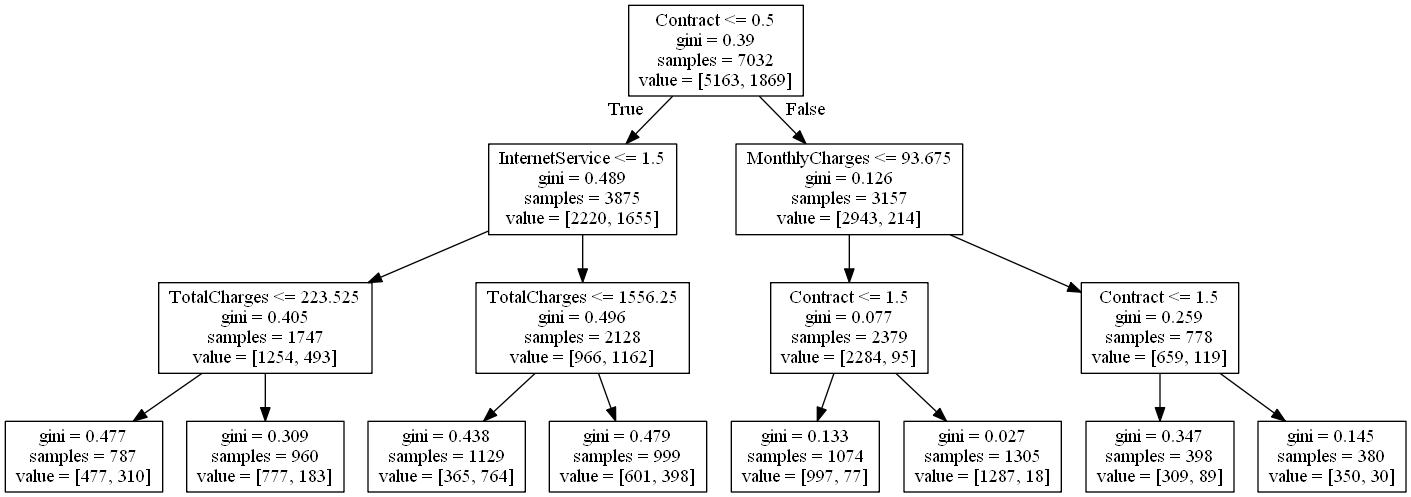

In [26]:
draw_decision_tree(model)

- 장기 계약 고객일수록 장기 계약에 따른 서비스 이탈이 없고, 대신 지속적인 수입을 보장한다는 측면에서 장기 계약에 한해 할인을 제공하고, 그에 대한 해지에 위약금이 존재하므로 당연히 계약 형태가 단기적일수록 이탈을 많이할 수 밖에 없지 않은가?

In [293]:
tele_data = tele_data.drop('Contract',1)

In [ ]:
tele_data = tele_data.drop('InternetService',1)

In [363]:
X_data = tele_data.iloc[:,:-2]
y = tele_data.iloc[:,-2]

In [365]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
model.fit(X_data, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

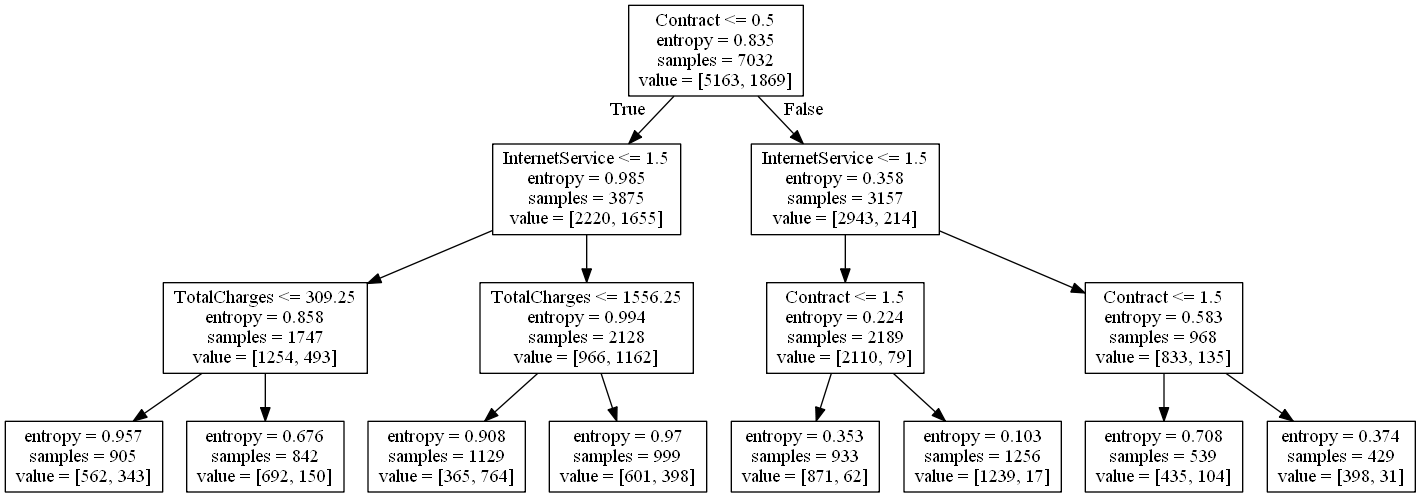

In [366]:
draw_decision_tree(model)

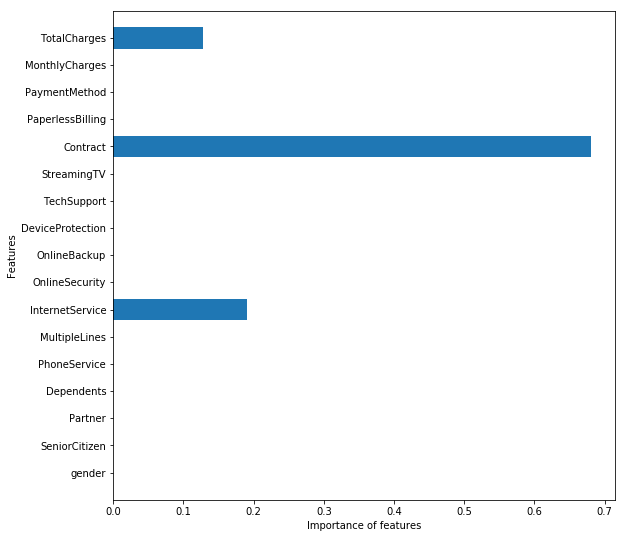

In [367]:
plt.figure(figsize=(9,9))
def plot_feature_importances_(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_data.columns.values)
    plt.xlabel("Importance of features")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
plot_feature_importances_(model)

In [368]:
X_data
X_data = X_data.drop('Contract',1)

In [369]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
model.fit(X_data, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

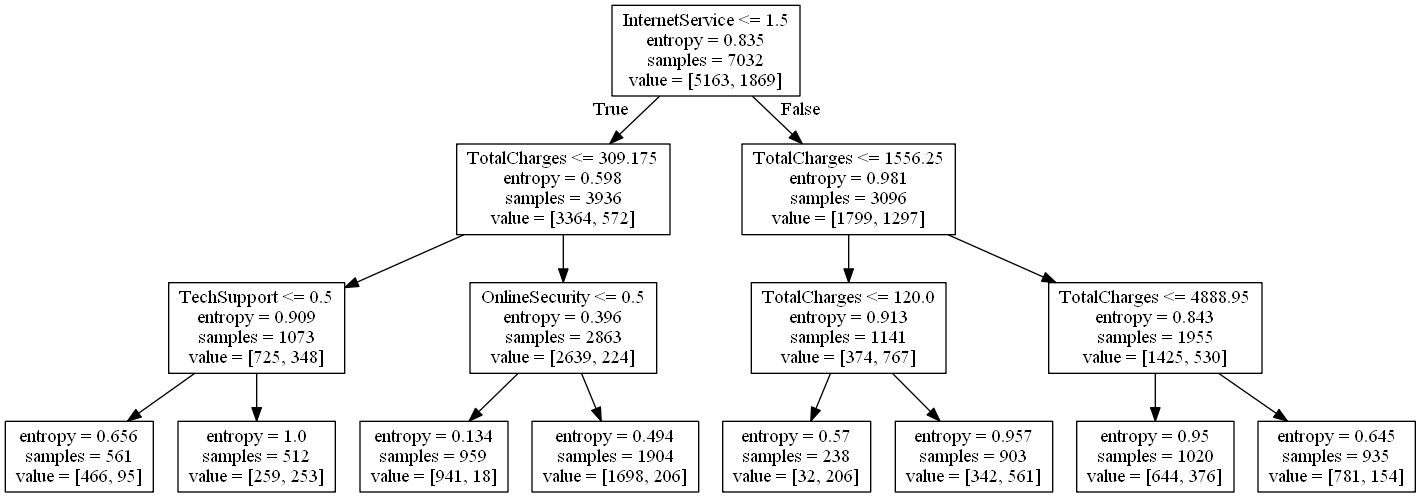

In [370]:
draw_decision_tree(model)

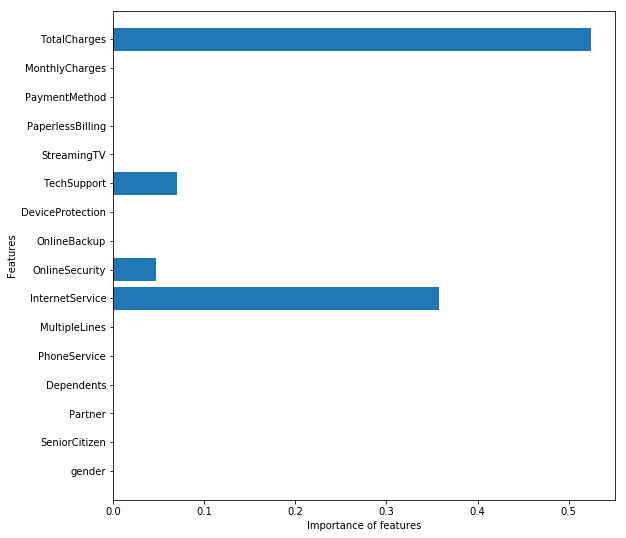

In [371]:
plt.figure(figsize=(9,9))
def plot_feature_importances_(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_data.columns.values)
    plt.xlabel("Importance of features")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
plot_feature_importances_(model)

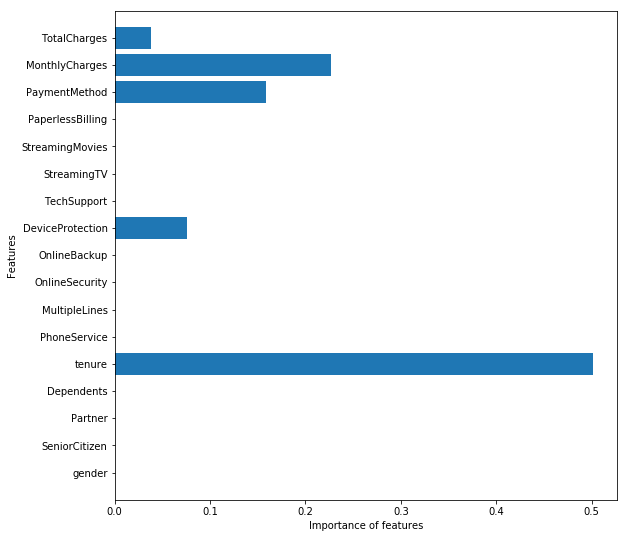

In [298]:
plt.figure(figsize=(9,9))
def plot_feature_importances_(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_data.columns.values)
    plt.xlabel("Importance of features")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
plot_feature_importances_(model)

In [250]:
def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    
    plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], s=80, label=cl)

    plt.xlabel(iris.feature_names[2])
    plt.ylabel(iris.feature_names[3])
    plt.legend(loc='upper left')
    plt.title(title)
    
    return Z

In [ ]:
plot_decision_regions(X_data, y, model, 'customer churn analysis')

In [404]:
model.feature_importances_

array([0.        , 0.00238984, 0.        , 0.        , 0.15661421,
       0.        , 0.01879921, 0.15671762, 0.00282806, 0.01742277,
       0.        , 0.        , 0.        , 0.01502509, 0.55444026,
       0.        , 0.02310946, 0.01065113, 0.04200234])

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


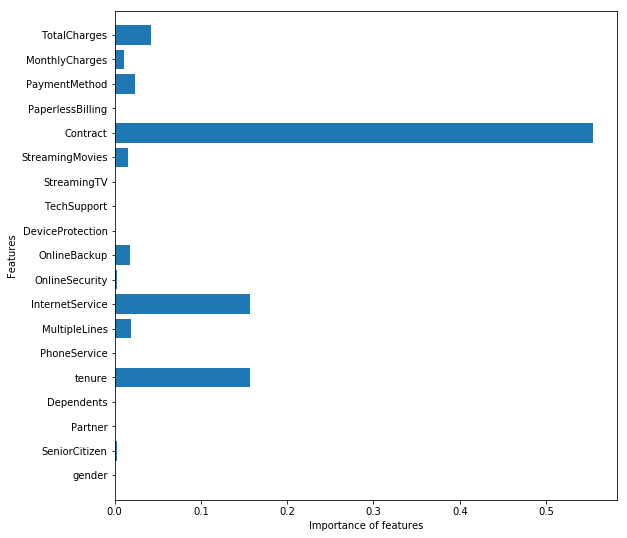

In [405]:
plt.figure(figsize=(9,9))
def plot_feature_importances_(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_data.columns.values)
    plt.xlabel("Importance of features")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
plot_feature_importances_(model)

- 엔트로피 기준으로 의사결정나무 분석 실시한 결과, Contract 특성의 중요도가 가장 높게 나옴
- 그 이외에도 InternetService와 tenure의 중요도가 0.18 수준으로 나타남.

- MonthlyCharges와 Contract 형태, TotalCharges와 tenure가 주요한 특성으로 나타남
- 특성 중요도가 낮은 수준이므로, 중요도 수치가 낮은 특성들을 제거하고 다시 시행해본다

In [ ]:
plt.figure(figsize=(9,9))
def plot_feature_importances_(model):
    n_features = X_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),X_data.columns.values)
    plt.xlabel("Importance of features")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)
plot_feature_importances_(tree)

In [70]:
#특성 삭제1
tele_data = tele_data.drop('PhoneService', 1)
tele_data = tele_data.drop('StreamingTV', 1)
tele_data = tele_data.drop('Dependents', 1)

In [77]:
#특성 삭제2
tele_data = tele_data.drop('StreamingMovies', 1)
tele_data = tele_data.drop('OnlineSecurity', 1)
tele_data = tele_data.drop('SeniorCitizen', 1)
tele_data = tele_data.drop('MultipleLines', 1)
tele_data = tele_data.drop('TechSupport', 1)

In [84]:
#특성 삭제3
tele_data = tele_data.drop('Partner', 1)
tele_data = tele_data.drop('gender', 1)
tele_data = tele_data.drop('DeviceProtection', 1)
tele_data = tele_data.drop('OnlineBackup', 1)
tele_data = tele_data.drop('PaymentMethod', 1)
tele_data = tele_data.drop('PaperlessBilling', 1)

In [342]:
X_data.columns.values

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

### 랜덤 포레스트(미정)

In [92]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

In [ ]:
forest_classify()

## 판별분석

In [357]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)

In [358]:
lda.fit(X_data,y)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [359]:
X_train_lda = lda.fit_transform(x_train, y_train) # 축소된 훈련, 테스트 데이터 생성
X_test_lda = lda.fit_transform(x_test, y_test)

In [360]:
X_lda = lda.fit_transform(X_data, y)

In [361]:
from sklearn.linear_model import LogisticRegression # 로지스틱 분류로 성능 테스트
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

In [362]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [363]:
lr.predict_proba(X_test_lda[0,:].reshape(-1, 1)) #해당 분류에 속할 확률값으로 결과 도출
y_pred_lr=lr.predict(X_test_lda.reshape(-1, 1))

In [364]:
y_pred_lr

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [365]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_lr))

Accuracy: 0.80
